In [1]:
!pip install pyspark

In [2]:
!pip install pymongo

In [3]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql.types import DateType
from pyspark.sql import functions as f
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkFiles

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymongo
import pickle
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [4]:
spark = SparkSession \
    .builder \
    .appName("Flight-Price-Prediction") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/test.coll") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/test.coll") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1').getOrCreate()

In [5]:
url = "https://raw.githubusercontent.com/sdhumal2902/Flight_Dataset/main/Data_Train.csv"

In [6]:
spark.sparkContext.addFile(url)

In [7]:
train_data = spark.read.csv(SparkFiles.get("Data_Train.csv"), inferSchema=True, header=True)

In [8]:
train_data.show()

+-----------------+-------------------+--------+-----------+--------------------+-------------------+-------------------+--------+-----------+--------------------+-----+
|          Airline|    Date_of_Journey|  Source|Destination|               Route|           Dep_Time|       Arrival_Time|Duration|Total_Stops|     Additional_Info|Price|
+-----------------+-------------------+--------+-----------+--------------------+-------------------+-------------------+--------+-----------+--------------------+-----+
|           IndiGo|2019-03-24 00:00:00|Banglore|  New Delhi|           BLR ? DEL|2022-09-20 22:20:00|2022-09-20 01:10:00|  2h 50m|   non-stop|             No info| 3897|
|        Air India|2019-05-01 00:00:00| Kolkata|   Banglore|CCU ? IXR ? BBI ?...|2022-09-20 05:50:00|2022-09-20 13:15:00|  7h 25m|    2 stops|             No info| 7662|
|      Jet Airways|2019-06-09 00:00:00|   Delhi|     Cochin|DEL ? LKO ? BOM ?...|2022-09-20 09:25:00|2022-09-20 04:25:00|     19h|    2 stops|        

In [9]:
train_data.printSchema()

root
 |-- Airline: string (nullable = true)
 |-- Date_of_Journey: timestamp (nullable = true)
 |-- Source: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Route: string (nullable = true)
 |-- Dep_Time: timestamp (nullable = true)
 |-- Arrival_Time: timestamp (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Total_Stops: string (nullable = true)
 |-- Additional_Info: string (nullable = true)
 |-- Price: integer (nullable = true)



In [10]:
from pyspark.sql.types import DateType
train_data = train_data.withColumn("Date_of_Journey", train_data["Date_of_Journey"].cast(DateType()))

In [11]:
train_data.printSchema()
train_data.select('Date_of_Journey').show()

root
 |-- Airline: string (nullable = true)
 |-- Date_of_Journey: date (nullable = true)
 |-- Source: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Route: string (nullable = true)
 |-- Dep_Time: timestamp (nullable = true)
 |-- Arrival_Time: timestamp (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Total_Stops: string (nullable = true)
 |-- Additional_Info: string (nullable = true)
 |-- Price: integer (nullable = true)

+---------------+
|Date_of_Journey|
+---------------+
|     2019-03-24|
|     2019-05-01|
|     2019-06-09|
|     2019-05-12|
|     2019-03-01|
|     2019-06-24|
|     2019-03-12|
|     2019-03-01|
|     2019-03-12|
|     2019-05-27|
|     2019-06-01|
|     2019-04-18|
|     2019-06-24|
|     2019-05-09|
|     2019-04-24|
|     2019-03-03|
|     2019-04-15|
|     2019-06-12|
|     2019-06-12|
|     2019-05-27|
+---------------+
only showing top 20 rows



In [12]:
train_data.count()
train_data.columns

['Airline',
 'Date_of_Journey',
 'Source',
 'Destination',
 'Route',
 'Dep_Time',
 'Arrival_Time',
 'Duration',
 'Total_Stops',
 'Additional_Info',
 'Price']

In [13]:
url_fest = "https://raw.githubusercontent.com/sdhumal2902/Flight_Dataset/main/2019.csv"

In [14]:
spark.sparkContext.addFile(url_fest)

In [15]:
fs_data = spark.read.csv(SparkFiles.get("2019.csv"), inferSchema=True, header=True)

In [16]:
fs_data.schema

StructType([StructField('date', TimestampType(), True), StructField('day', StringType(), True), StructField('holiday', StringType(), True), StructField('holiday_type', StringType(), True)])

In [17]:
fs_data = fs_data.drop('holiday_type', 'day')

In [18]:
fs_data.show()

+-------------------+--------------------+
|               date|             holiday|
+-------------------+--------------------+
|2019-01-01 00:00:00|  New Year's Day (R)|
|2019-01-13 00:00:00|Guru Gobind Singh...|
|2019-01-14 00:00:00| Makar Sankranti (R)|
|2019-01-15 00:00:00|          Pongal (R)|
|2019-01-26 00:00:00|    Republic Day (G)|
|2019-02-10 00:00:00|Basant Panchami /...|
|2019-02-19 00:00:00|Guru Ravidas's Bi...|
|2019-03-01 00:00:00|Swami Dayananda S...|
|2019-03-04 00:00:00| Maha Shivaratri (G)|
|2019-03-20 00:00:00|    Holika Dahan (R)|
|2019-03-21 00:00:00|        Dolyatra (R)|
|2019-04-06 00:00:00|Chaitra Sukladi/ ...|
|2019-04-13 00:00:00|Ram Navami (Smart...|
|2019-04-14 00:00:00|Vaisakhi/ Vishu/ ...|
|2019-04-15 00:00:00|Vaisakhadi (Benga...|
|2019-04-17 00:00:00| Mahavir Jayanti (G)|
|2019-04-19 00:00:00|     Good Friday (G)|
|2019-04-21 00:00:00|   Easter Sunday (R)|
|2019-05-09 00:00:00|Guru Rabindranath...|
|2019-05-18 00:00:00|  Buddha Purnima (G)|
+----------

In [19]:
from pyspark.sql.types import DateType
fs_data = fs_data.withColumn("date", fs_data["date"].cast(DateType()))

In [20]:
fs_data.printSchema()

root
 |-- date: date (nullable = true)
 |-- holiday: string (nullable = true)



In [21]:
fs_data.show()

+----------+--------------------+
|      date|             holiday|
+----------+--------------------+
|2019-01-01|  New Year's Day (R)|
|2019-01-13|Guru Gobind Singh...|
|2019-01-14| Makar Sankranti (R)|
|2019-01-15|          Pongal (R)|
|2019-01-26|    Republic Day (G)|
|2019-02-10|Basant Panchami /...|
|2019-02-19|Guru Ravidas's Bi...|
|2019-03-01|Swami Dayananda S...|
|2019-03-04| Maha Shivaratri (G)|
|2019-03-20|    Holika Dahan (R)|
|2019-03-21|        Dolyatra (R)|
|2019-04-06|Chaitra Sukladi/ ...|
|2019-04-13|Ram Navami (Smart...|
|2019-04-14|Vaisakhi/ Vishu/ ...|
|2019-04-15|Vaisakhadi (Benga...|
|2019-04-17| Mahavir Jayanti (G)|
|2019-04-19|     Good Friday (G)|
|2019-04-21|   Easter Sunday (R)|
|2019-05-09|Guru Rabindranath...|
|2019-05-18|  Buddha Purnima (G)|
+----------+--------------------+
only showing top 20 rows



In [22]:
fs_data.columns

['date', 'holiday']

In [23]:
train_data = train_data.join(fs_data, train_data.Date_of_Journey == fs_data.date,how='left')
train_data.show()

+-----------------+---------------+--------+-----------+--------------------+-------------------+-------------------+--------+-----------+--------------------+-----+----------+--------------------+
|          Airline|Date_of_Journey|  Source|Destination|               Route|           Dep_Time|       Arrival_Time|Duration|Total_Stops|     Additional_Info|Price|      date|             holiday|
+-----------------+---------------+--------+-----------+--------------------+-------------------+-------------------+--------+-----------+--------------------+-----+----------+--------------------+
|           IndiGo|     2019-03-24|Banglore|  New Delhi|           BLR ? DEL|2022-09-20 22:20:00|2022-09-20 01:10:00|  2h 50m|   non-stop|             No info| 3897|      null|                null|
|        Air India|     2019-05-01| Kolkata|   Banglore|CCU ? IXR ? BBI ?...|2022-09-20 05:50:00|2022-09-20 13:15:00|  7h 25m|    2 stops|             No info| 7662|      null|                null|
|      Jet

In [24]:
train_data.count()
train_data.columns

['Airline',
 'Date_of_Journey',
 'Source',
 'Destination',
 'Route',
 'Dep_Time',
 'Arrival_Time',
 'Duration',
 'Total_Stops',
 'Additional_Info',
 'Price',
 'date',
 'holiday']

In [25]:
from pyspark.sql.functions import when, col
train_data = train_data.withColumn("holiday", when(train_data.holiday != "null", "Holiday").otherwise("Non Holiday"))
train_data.select('Date_of_Journey', 'holiday').show()

+---------------+-----------+
|Date_of_Journey|    holiday|
+---------------+-----------+
|     2019-03-24|Non Holiday|
|     2019-05-01|Non Holiday|
|     2019-06-09|Non Holiday|
|     2019-05-12|Non Holiday|
|     2019-03-01|    Holiday|
|     2019-06-24|Non Holiday|
|     2019-03-12|Non Holiday|
|     2019-03-01|    Holiday|
|     2019-03-12|Non Holiday|
|     2019-05-27|Non Holiday|
|     2019-06-01|Non Holiday|
|     2019-04-18|Non Holiday|
|     2019-06-24|Non Holiday|
|     2019-05-09|    Holiday|
|     2019-04-24|Non Holiday|
|     2019-03-03|Non Holiday|
|     2019-04-15|    Holiday|
|     2019-06-12|Non Holiday|
|     2019-06-12|Non Holiday|
|     2019-05-27|Non Holiday|
+---------------+-----------+
only showing top 20 rows



In [26]:
train_data = train_data.drop('date')
train_data.columns

['Airline',
 'Date_of_Journey',
 'Source',
 'Destination',
 'Route',
 'Dep_Time',
 'Arrival_Time',
 'Duration',
 'Total_Stops',
 'Additional_Info',
 'Price',
 'holiday']

In [27]:
train_data = train_data.withColumn("day", f.date_format("Date_of_Journey", "E"))
train_data.select('Date_of_Journey', 'day').show()

+---------------+---+
|Date_of_Journey|day|
+---------------+---+
|     2019-03-24|Sun|
|     2019-05-01|Wed|
|     2019-06-09|Sun|
|     2019-05-12|Sun|
|     2019-03-01|Fri|
|     2019-06-24|Mon|
|     2019-03-12|Tue|
|     2019-03-01|Fri|
|     2019-03-12|Tue|
|     2019-05-27|Mon|
|     2019-06-01|Sat|
|     2019-04-18|Thu|
|     2019-06-24|Mon|
|     2019-05-09|Thu|
|     2019-04-24|Wed|
|     2019-03-03|Sun|
|     2019-04-15|Mon|
|     2019-06-12|Wed|
|     2019-06-12|Wed|
|     2019-05-27|Mon|
+---------------+---+
only showing top 20 rows



In [28]:
train_data = train_data.withColumn("day", when(train_data.day == "Sat", "Weekend").when(train_data.day == "Sun", "Weekend").otherwise("Weekday"))
train_data.select('Date_of_Journey', 'day').show()

+---------------+-------+
|Date_of_Journey|    day|
+---------------+-------+
|     2019-03-24|Weekend|
|     2019-05-01|Weekday|
|     2019-06-09|Weekend|
|     2019-05-12|Weekend|
|     2019-03-01|Weekday|
|     2019-06-24|Weekday|
|     2019-03-12|Weekday|
|     2019-03-01|Weekday|
|     2019-03-12|Weekday|
|     2019-05-27|Weekday|
|     2019-06-01|Weekend|
|     2019-04-18|Weekday|
|     2019-06-24|Weekday|
|     2019-05-09|Weekday|
|     2019-04-24|Weekday|
|     2019-03-03|Weekend|
|     2019-04-15|Weekday|
|     2019-06-12|Weekday|
|     2019-06-12|Weekday|
|     2019-05-27|Weekday|
+---------------+-------+
only showing top 20 rows



In [29]:
train_data = train_data.drop("date")
train_data.columns

['Airline',
 'Date_of_Journey',
 'Source',
 'Destination',
 'Route',
 'Dep_Time',
 'Arrival_Time',
 'Duration',
 'Total_Stops',
 'Additional_Info',
 'Price',
 'holiday',
 'day']

In [30]:
from pyspark.sql.functions import *
from datetime import datetime
import pyspark.sql.functions as sqlFunc
import pyspark.sql.types as types
from pyspark.sql import functions as F
from pyspark.sql.functions import to_timestamp

In [31]:
# Journey Day
train_data = train_data.withColumn('Journey_Day', dayofmonth('Date_of_Journey'))

# Journey Month
train_data = train_data.withColumn('Journey_Month',month('Date_of_Journey'))

train_data = train_data.drop('Date_of_Journey')

train_data.printSchema()
train_data.select('Journey_Day','Journey_Month').show()

root
 |-- Airline: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Route: string (nullable = true)
 |-- Dep_Time: timestamp (nullable = true)
 |-- Arrival_Time: timestamp (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Total_Stops: string (nullable = true)
 |-- Additional_Info: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- holiday: string (nullable = false)
 |-- day: string (nullable = false)
 |-- Journey_Day: integer (nullable = true)
 |-- Journey_Month: integer (nullable = true)

+-----------+-------------+
|Journey_Day|Journey_Month|
+-----------+-------------+
|         24|            3|
|          1|            5|
|          9|            6|
|         12|            5|
|          1|            3|
|         24|            6|
|         12|            3|
|          1|            3|
|         12|            3|
|         27|            5|
|          1|            6|
|         18|        

In [32]:
# Split Hour from Dep_Time column
train_data = train_data.withColumn('Dep_Hour',hour('Dep_Time'))

# Split minute from Dep_Time column
train_data = train_data.withColumn('Dep_Minute',minute('Dep_Time'))

train_data = train_data.drop('Dep_Time')

train_data.select('Dep_Hour', 'Dep_Minute').show()

+--------+----------+
|Dep_Hour|Dep_Minute|
+--------+----------+
|      22|        20|
|       5|        50|
|       9|        25|
|      18|         5|
|      16|        50|
|       9|         0|
|      18|        55|
|       8|         0|
|       8|        55|
|      11|        25|
|       9|        45|
|      20|        20|
|      11|        40|
|      21|        10|
|      17|        15|
|      16|        40|
|       8|        45|
|      14|         0|
|      20|        15|
|      16|         0|
+--------+----------+
only showing top 20 rows



In [33]:
# Split Hour from Arrival_Time column
train_data = train_data.withColumn('Arrival_hour',hour('Arrival_Time'))

# Split minute from Arrival_Time column
train_data = train_data.withColumn('Arrival_min',minute('Arrival_Time'))

# To reduce the redendancy we droped Arrival_Time.
train_data = train_data.drop('Arrival_Time')

train_data.select('Arrival_hour', 'Arrival_min').show()

+------------+-----------+
|Arrival_hour|Arrival_min|
+------------+-----------+
|           1|         10|
|          13|         15|
|           4|         25|
|          23|         30|
|          21|         35|
|          11|         25|
|          10|         25|
|           5|          5|
|          10|         25|
|          19|         15|
|          23|          0|
|          22|         55|
|          13|         55|
|           9|         20|
|          19|         50|
|          19|         15|
|          13|         15|
|          12|         35|
|          19|         15|
|          12|         35|
+------------+-----------+
only showing top 20 rows



In [34]:
# Split hour and minute from duration column
train_data = train_data.withColumn('Duration_Hour', split(train_data['Duration'], ' ').getItem(0)).withColumn('Duration_Minute', split(train_data['Duration'],' ').getItem(1))

train_data.select('Duration_Hour',"Duration_Minute").show()

+-------------+---------------+
|Duration_Hour|Duration_Minute|
+-------------+---------------+
|           2h|            50m|
|           7h|            25m|
|          19h|           null|
|           5h|            25m|
|           4h|            45m|
|           2h|            25m|
|          15h|            30m|
|          21h|             5m|
|          25h|            30m|
|           7h|            50m|
|          13h|            15m|
|           2h|            35m|
|           2h|            15m|
|          12h|            10m|
|           2h|            35m|
|          26h|            35m|
|           4h|            30m|
|          22h|            35m|
|          23h|           null|
|          20h|            35m|
+-------------+---------------+
only showing top 20 rows



In [35]:
# Handle null values in Duration_Hour 
train_data = train_data.withColumn("Duration_Hour", expr("CASE WHEN Duration_Hour IS NULL THEN '0h' " +  "ELSE Duration_Hour END"))

# Handle null values in Duration_Minute
train_data = train_data.withColumn("Duration_Minute", expr("CASE WHEN Duration_Minute IS NULL THEN '0m' " +  "ELSE Duration_Minute END"))

train_data= train_data.drop('Duration')
train_data.columns

train_data.select('Duration_Hour','Duration_Minute').show()

+-------------+---------------+
|Duration_Hour|Duration_Minute|
+-------------+---------------+
|           2h|            50m|
|           7h|            25m|
|          19h|             0m|
|           5h|            25m|
|           4h|            45m|
|           2h|            25m|
|          15h|            30m|
|          21h|             5m|
|          25h|            30m|
|           7h|            50m|
|          13h|            15m|
|           2h|            35m|
|           2h|            15m|
|          12h|            10m|
|           2h|            35m|
|          26h|            35m|
|           4h|            30m|
|          22h|            35m|
|          23h|             0m|
|          20h|            35m|
+-------------+---------------+
only showing top 20 rows



In [36]:
# get values minute 
train_data = train_data.withColumn("Duration_Minute", regexp_extract("Duration_Minute", r'(\d+)m' , 1 ))

# get values hour
train_data = train_data.withColumn("Duration_Hour", regexp_extract("Duration_Hour", r'(\d+)h' , 1 ))

train_data.select('Duration_Hour','Duration_Minute').show()

+-------------+---------------+
|Duration_Hour|Duration_Minute|
+-------------+---------------+
|            2|             50|
|            7|             25|
|           19|              0|
|            5|             25|
|            4|             45|
|            2|             25|
|           15|             30|
|           21|              5|
|           25|             30|
|            7|             50|
|           13|             15|
|            2|             35|
|            2|             15|
|           12|             10|
|            2|             35|
|           26|             35|
|            4|             30|
|           22|             35|
|           23|              0|
|           20|             35|
+-------------+---------------+
only showing top 20 rows



In [37]:
train_data= train_data.drop('Duration')
train_data.printSchema()

root
 |-- Airline: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Route: string (nullable = true)
 |-- Total_Stops: string (nullable = true)
 |-- Additional_Info: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- holiday: string (nullable = false)
 |-- day: string (nullable = false)
 |-- Journey_Day: integer (nullable = true)
 |-- Journey_Month: integer (nullable = true)
 |-- Dep_Hour: integer (nullable = true)
 |-- Dep_Minute: integer (nullable = true)
 |-- Arrival_hour: integer (nullable = true)
 |-- Arrival_min: integer (nullable = true)
 |-- Duration_Hour: string (nullable = true)
 |-- Duration_Minute: string (nullable = true)



In [38]:
from pyspark.sql.types import IntegerType
train_data = train_data.withColumn('Duration_Hour', train_data.Duration_Hour.cast(IntegerType()))

train_data = train_data.withColumn('Duration_Minute', train_data.Duration_Hour.cast(IntegerType()))

train_data.select('Duration_Hour','Duration_Minute').show()

+-------------+---------------+
|Duration_Hour|Duration_Minute|
+-------------+---------------+
|            2|              2|
|            7|              7|
|           19|             19|
|            5|              5|
|            4|              4|
|            2|              2|
|           15|             15|
|           21|             21|
|           25|             25|
|            7|              7|
|           13|             13|
|            2|              2|
|            2|              2|
|           12|             12|
|            2|              2|
|           26|             26|
|            4|              4|
|           22|             22|
|           23|             23|
|           20|             20|
+-------------+---------------+
only showing top 20 rows



In [39]:
from pyspark.sql.functions import isnan, when, count, col
train_data.select([count(when(col(c).isNull(), c)).alias(c) for c in train_data.columns]).show()

+-------+------+-----------+-----+-----------+---------------+-----+-------+---+-----------+-------------+--------+----------+------------+-----------+-------------+---------------+
|Airline|Source|Destination|Route|Total_Stops|Additional_Info|Price|holiday|day|Journey_Day|Journey_Month|Dep_Hour|Dep_Minute|Arrival_hour|Arrival_min|Duration_Hour|Duration_Minute|
+-------+------+-----------+-----+-----------+---------------+-----+-------+---+-----------+-------------+--------+----------+------------+-----------+-------------+---------------+
|      0|     0|          0|    1|          1|              0|    0|      0|  0|          0|            0|       0|         0|           0|          0|            1|              1|
+-------+------+-----------+-----+-----------+---------------+-----+-------+---+-----------+-------------+--------+----------+------------+-----------+-------------+---------------+



In [40]:
### Drop rows with NA or missing values in pyspark
train_data = train_data.na.drop()

In [41]:
from pyspark.sql.functions import isnan, when, count, col
train_data.select([count(when(col(c).isNull(), c)).alias(c) for c in train_data.columns]).show()

+-------+------+-----------+-----+-----------+---------------+-----+-------+---+-----------+-------------+--------+----------+------------+-----------+-------------+---------------+
|Airline|Source|Destination|Route|Total_Stops|Additional_Info|Price|holiday|day|Journey_Day|Journey_Month|Dep_Hour|Dep_Minute|Arrival_hour|Arrival_min|Duration_Hour|Duration_Minute|
+-------+------+-----------+-----+-----------+---------------+-----+-------+---+-----------+-------------+--------+----------+------------+-----------+-------------+---------------+
|      0|     0|          0|    0|          0|              0|    0|      0|  0|          0|            0|       0|         0|           0|          0|            0|              0|
+-------+------+-----------+-----+-----------+---------------+-----+-------+---+-----------+-------------+--------+----------+------------+-----------+-------------+---------------+



In [42]:
train_data.select(countDistinct('Total_Stops')).show()

+---------------------------+
|count(DISTINCT Total_Stops)|
+---------------------------+
|                          5|
+---------------------------+



In [43]:
train_data.select('Total_Stops').distinct().collect()

[Row(Total_Stops='4 stops'),
 Row(Total_Stops='non-stop'),
 Row(Total_Stops='2 stops'),
 Row(Total_Stops='1 stop'),
 Row(Total_Stops='3 stops')]

In [44]:
train_data.groupBy('Total_Stops').count().alias('Count').sort(col('Count').desc()).show()

+-----------+-----+
|Total_Stops|count|
+-----------+-----+
|     1 stop| 5625|
|   non-stop| 3491|
|    2 stops| 1519|
|    3 stops|   45|
|    4 stops|    1|
+-----------+-----+



In [45]:
train_data = train_data.withColumn('Total_Stops',when(col('Total_Stops')=='1 stop',1)
                                                    .when(col('Total_Stops')=='2 stops',2)
                                                    .when(col('Total_Stops')=='3 stops',3)
                                                    .when(col('Total_Stops')=='4 stops',4)
                                                    .otherwise(0))

In [46]:
train_data.select('Total_Stops').show()

+-----------+
|Total_Stops|
+-----------+
|          0|
|          2|
|          2|
|          1|
|          1|
|          0|
|          1|
|          1|
|          1|
|          1|
|          1|
|          0|
|          0|
|          1|
|          0|
|          2|
|          1|
|          1|
|          2|
|          1|
+-----------+
only showing top 20 rows



In [47]:
from pyspark.sql.functions import isnan, when, count, col
train_data.select([count(when(col(c).isNull(), c)).alias(c) for c in train_data.columns]).show()

+-------+------+-----------+-----+-----------+---------------+-----+-------+---+-----------+-------------+--------+----------+------------+-----------+-------------+---------------+
|Airline|Source|Destination|Route|Total_Stops|Additional_Info|Price|holiday|day|Journey_Day|Journey_Month|Dep_Hour|Dep_Minute|Arrival_hour|Arrival_min|Duration_Hour|Duration_Minute|
+-------+------+-----------+-----+-----------+---------------+-----+-------+---+-----------+-------------+--------+----------+------------+-----------+-------------+---------------+
|      0|     0|          0|    0|          0|              0|    0|      0|  0|          0|            0|       0|         0|           0|          0|            0|              0|
+-------+------+-----------+-----+-----------+---------------+-----+-------+---+-----------+-------------+--------+----------+------------+-----------+-------------+---------------+



In [48]:
train_data.printSchema()

root
 |-- Airline: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Route: string (nullable = true)
 |-- Total_Stops: integer (nullable = false)
 |-- Additional_Info: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- holiday: string (nullable = false)
 |-- day: string (nullable = false)
 |-- Journey_Day: integer (nullable = true)
 |-- Journey_Month: integer (nullable = true)
 |-- Dep_Hour: integer (nullable = true)
 |-- Dep_Minute: integer (nullable = true)
 |-- Arrival_hour: integer (nullable = true)
 |-- Arrival_min: integer (nullable = true)
 |-- Duration_Hour: integer (nullable = true)
 |-- Duration_Minute: integer (nullable = true)



In [49]:
train_data.show()

+-----------------+--------+-----------+--------------------+-----------+--------------------+-----+-----------+-------+-----------+-------------+--------+----------+------------+-----------+-------------+---------------+
|          Airline|  Source|Destination|               Route|Total_Stops|     Additional_Info|Price|    holiday|    day|Journey_Day|Journey_Month|Dep_Hour|Dep_Minute|Arrival_hour|Arrival_min|Duration_Hour|Duration_Minute|
+-----------------+--------+-----------+--------------------+-----------+--------------------+-----+-----------+-------+-----------+-------------+--------+----------+------------+-----------+-------------+---------------+
|           IndiGo|Banglore|  New Delhi|           BLR ? DEL|          0|             No info| 3897|Non Holiday|Weekend|         24|            3|      22|        20|           1|         10|            2|              2|
|        Air India| Kolkata|   Banglore|CCU ? IXR ? BBI ?...|          2|             No info| 7662|Non Holiday|

In [50]:
train_data.printSchema()

root
 |-- Airline: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Route: string (nullable = true)
 |-- Total_Stops: integer (nullable = false)
 |-- Additional_Info: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- holiday: string (nullable = false)
 |-- day: string (nullable = false)
 |-- Journey_Day: integer (nullable = true)
 |-- Journey_Month: integer (nullable = true)
 |-- Dep_Hour: integer (nullable = true)
 |-- Dep_Minute: integer (nullable = true)
 |-- Arrival_hour: integer (nullable = true)
 |-- Arrival_min: integer (nullable = true)
 |-- Duration_Hour: integer (nullable = true)
 |-- Duration_Minute: integer (nullable = true)



In [51]:
len(train_data.columns)

17

In [52]:
type(train_data)

pyspark.sql.dataframe.DataFrame

In [53]:
train_data.write.format("mongo").mode("overwrite").option("database","project").option("collection", "Flight").save()

In [54]:
# flight as a train data set.
client = MongoClient('localhost',27017)
db = client['project']
data = db.Flight
df = pd.DataFrame(list(data.find()))
df

,_id,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,holiday,day,Journey_Day,Journey_Month,Dep_Hour,Dep_Minute,Arrival_hour,Arrival_min,Duration_Hour,Duration_Minute
0,6329df618a05eb6cc1e176eb,IndiGo,Banglore,New Delhi,BLR ? DEL,0,No info,3897,Non Holiday,Weekend,24,3,22,20,1,10,2,2
1,6329df618a05eb6cc1e176ec,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,2,No info,7662,Non Holiday,Weekday,1,5,5,50,13,15,7,7
2,6329df618a05eb6cc1e176ed,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,2,No info,13882,Non Holiday,Weekend,9,6,9,25,4,25,19,19
3,6329df618a05eb6cc1e176ee,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,1,No info,6218,Non Holiday,Weekend,12,5,18,5,23,30,5,5
4,6329df618a05eb6cc1e176ef,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,1,No info,13302,Holiday,Weekday,1,3,16,50,21,35,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10676,6329df638a05eb6cc1e1a09f,Air Asia,Kolkata,Banglore,CCU ? BLR,0,No info,4107,Non Holiday,Weekday,9,4,19,55,22,25,2,2
10677,6329df638a05eb6cc1e1a0a0,Air India,Kolkata,Banglore,CCU ? BLR,0,No info,4145,Non Holiday,Weekend,27,4,20,45,23,20,2,2
10678,6329df638a05eb6cc1e1a0a1,Jet Airways,Banglore,Delhi,BLR ? DEL,0,No info,7229,Non Holiday,Weekend,27,4,8,20,11,20,3,3
10679,6329df638a05eb6cc1e1a0a2,Vistara,Banglore,New Delhi,BLR ? DEL,0,No info,12648,Holiday,Weekday,1,3,11,30,14,10,2,2


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [56]:
pd.set_option('display.max_columns', None)

In [57]:
df.head()

,_id,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,holiday,day,Journey_Day,Journey_Month,Dep_Hour,Dep_Minute,Arrival_hour,Arrival_min,Duration_Hour,Duration_Minute
0,6329df618a05eb6cc1e176eb,IndiGo,Banglore,New Delhi,BLR ? DEL,0,No info,3897,Non Holiday,Weekend,24,3,22,20,1,10,2,2
1,6329df618a05eb6cc1e176ec,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,2,No info,7662,Non Holiday,Weekday,1,5,5,50,13,15,7,7
2,6329df618a05eb6cc1e176ed,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,2,No info,13882,Non Holiday,Weekend,9,6,9,25,4,25,19,19
3,6329df618a05eb6cc1e176ee,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,1,No info,6218,Non Holiday,Weekend,12,5,18,5,23,30,5,5
4,6329df618a05eb6cc1e176ef,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,1,No info,13302,Holiday,Weekday,1,3,16,50,21,35,4,4


In [58]:
df.drop(["_id"], axis = 1, inplace = True)

In [59]:
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,holiday,day,Journey_Day,Journey_Month,Dep_Hour,Dep_Minute,Arrival_hour,Arrival_min,Duration_Hour,Duration_Minute
0,IndiGo,Banglore,New Delhi,BLR ? DEL,0,No info,3897,Non Holiday,Weekend,24,3,22,20,1,10,2,2
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,2,No info,7662,Non Holiday,Weekday,1,5,5,50,13,15,7,7
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,2,No info,13882,Non Holiday,Weekend,9,6,9,25,4,25,19,19
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,1,No info,6218,Non Holiday,Weekend,12,5,18,5,23,30,5,5
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,1,No info,13302,Holiday,Weekday,1,3,16,50,21,35,4,4


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10681 entries, 0 to 10680
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10681 non-null  object
 1   Source           10681 non-null  object
 2   Destination      10681 non-null  object
 3   Route            10681 non-null  object
 4   Total_Stops      10681 non-null  int64 
 5   Additional_Info  10681 non-null  object
 6   Price            10681 non-null  int64 
 7   holiday          10681 non-null  object
 8   day              10681 non-null  object
 9   Journey_Day      10681 non-null  int64 
 10  Journey_Month    10681 non-null  int64 
 11  Dep_Hour         10681 non-null  int64 
 12  Dep_Minute       10681 non-null  int64 
 13  Arrival_hour     10681 non-null  int64 
 14  Arrival_min      10681 non-null  int64 
 15  Duration_Hour    10681 non-null  int64 
 16  Duration_Minute  10681 non-null  int64 
dtypes: int64(10), object(7)
memory 

In [61]:
df["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1750
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

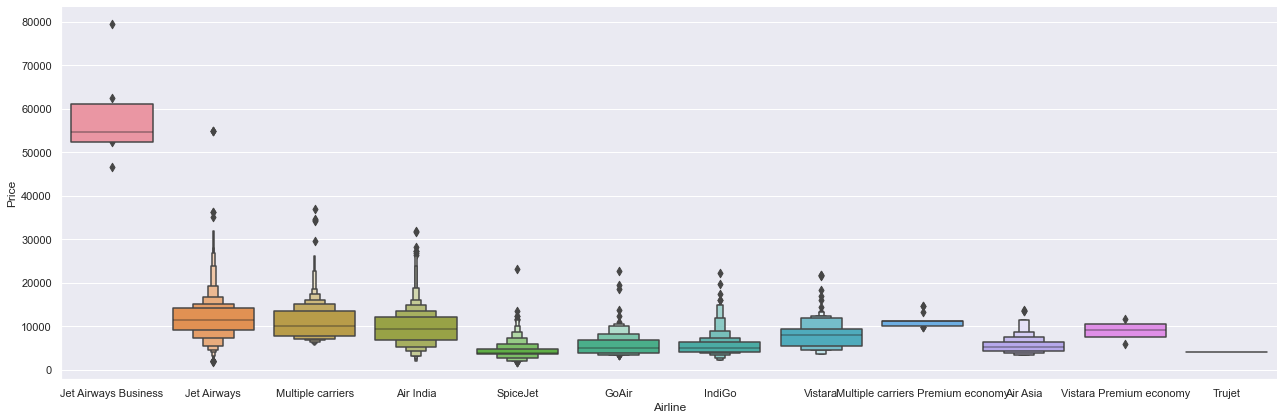

In [62]:
# From graph we can see that Jet Airways Business have the highest Price.
# Apart from the first Airline almost all are having similar median

# Airline vs Price
sns.catplot(y = "Price", x = "Airline", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

In [63]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding

Airline = df[["Airline"]]

Airline = pd.get_dummies(Airline, drop_first= True)

Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [64]:
df["Source"].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       696
Chennai      381
Name: Source, dtype: int64

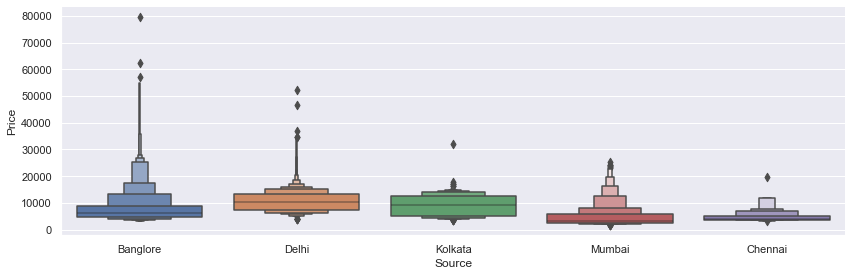

In [65]:
# Source vs Price

sns.catplot(y = "Price", x = "Source", data = df.sort_values("Price", ascending = False), kind="boxen", height = 4, aspect = 3)
plt.show()

In [66]:
# As Source is Nominal Categorical data we will perform OneHotEncoding

Source = df[["Source"]]

Source = pd.get_dummies(Source, drop_first= True)

Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [67]:
df["Destination"].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     696
Kolkata       381
Name: Destination, dtype: int64

In [68]:
# As Destination is Nominal Categorical data we will perform OneHotEncoding

Destination = df[["Destination"]]

Destination = pd.get_dummies(Destination, drop_first = True)

Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [69]:
df["holiday"].value_counts()

Non Holiday    8800
Holiday        1881
Name: holiday, dtype: int64

In [70]:
# As Holiday is Nominal Categorical data we will perform OneHotEncoding
holiday = df[["holiday"]]

holiday = pd.get_dummies(holiday, drop_first = True)

holiday.head()

,holiday_Non Holiday
0,1
1,1
2,1
3,1
4,0


In [71]:
df["day"].value_counts()

Weekday    7537
Weekend    3144
Name: day, dtype: int64

In [72]:
# As Holiday is Nominal Categorical data we will perform OneHotEncoding
day = df[["day"]]

day = pd.get_dummies(day, drop_first = True)

day.head()

,day_Weekend
0,1
1,0
2,1
3,1
4,0


In [73]:
df["Route"]

0                    BLR ? DEL
1        CCU ? IXR ? BBI ? BLR
2        DEL ? LKO ? BOM ? COK
3              CCU ? NAG ? BLR
4              BLR ? NAG ? DEL
                 ...          
10676                CCU ? BLR
10677                CCU ? BLR
10678                BLR ? DEL
10679                BLR ? DEL
10680    DEL ? GOI ? BOM ? COK
Name: Route, Length: 10681, dtype: object

In [74]:
# Additional_Info contains almost 80% no_info
# Route and Total_Stops are related to each other

df.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [75]:
df["Total_Stops"].value_counts()

1    5625
0    3491
2    1519
3      45
4       1
Name: Total_Stops, dtype: int64

In [76]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding keys

df.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

In [77]:
df.head()

,Airline,Source,Destination,Total_Stops,Price,holiday,day,Journey_Day,Journey_Month,Dep_Hour,Dep_Minute,Arrival_hour,Arrival_min,Duration_Hour,Duration_Minute
0,IndiGo,Banglore,New Delhi,0,3897,Non Holiday,Weekend,24,3,22,20,1,10,2,2
1,Air India,Kolkata,Banglore,2,7662,Non Holiday,Weekday,1,5,5,50,13,15,7,7
2,Jet Airways,Delhi,Cochin,2,13882,Non Holiday,Weekend,9,6,9,25,4,25,19,19
3,IndiGo,Kolkata,Banglore,1,6218,Non Holiday,Weekend,12,5,18,5,23,30,5,5
4,IndiGo,Banglore,New Delhi,1,13302,Holiday,Weekday,1,3,16,50,21,35,4,4


In [78]:
# Concatenate dataframe --> train_data + Airline + Source + Destination + holiday + day

df = pd.concat([df, Airline, Source, Destination, holiday, day], axis = 1)

In [79]:
df.head()

,Airline,Source,Destination,Total_Stops,Price,holiday,day,Journey_Day,Journey_Month,Dep_Hour,Dep_Minute,Arrival_hour,Arrival_min,Duration_Hour,Duration_Minute,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,holiday_Non Holiday,day_Weekend
0,IndiGo,Banglore,New Delhi,0,3897,Non Holiday,Weekend,24,3,22,20,1,10,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,Air India,Kolkata,Banglore,2,7662,Non Holiday,Weekday,1,5,5,50,13,15,7,7,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,Jet Airways,Delhi,Cochin,2,13882,Non Holiday,Weekend,9,6,9,25,4,25,19,19,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1
3,IndiGo,Kolkata,Banglore,1,6218,Non Holiday,Weekend,12,5,18,5,23,30,5,5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
4,IndiGo,Banglore,New Delhi,1,13302,Holiday,Weekday,1,3,16,50,21,35,4,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [80]:
df.drop(["Airline", "Source", "Destination", "holiday", "day"], axis = 1, inplace = True)

In [81]:
df.head()

,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Hour,Dep_Minute,Arrival_hour,Arrival_min,Duration_Hour,Duration_Minute,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,holiday_Non Holiday,day_Weekend
0,0,3897,24,3,22,20,1,10,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,2,7662,1,5,5,50,13,15,7,7,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,2,13882,9,6,9,25,4,25,19,19,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1
3,1,6218,12,5,18,5,23,30,5,5,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
4,1,13302,1,3,16,50,21,35,4,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [82]:
df.shape

(10681, 32)

In [83]:
df.dtypes

Total_Stops                                  int64
Price                                        int64
Journey_Day                                  int64
Journey_Month                                int64
Dep_Hour                                     int64
Dep_Minute                                   int64
Arrival_hour                                 int64
Arrival_min                                  int64
Duration_Hour                                int64
Duration_Minute                              int64
Airline_Air India                            uint8
Airline_GoAir                                uint8
Airline_IndiGo                               uint8
Airline_Jet Airways                          uint8
Airline_Jet Airways Business                 uint8
Airline_Multiple carriers                    uint8
Airline_Multiple carriers Premium economy    uint8
Airline_SpiceJet                             uint8
Airline_Trujet                               uint8
Airline_Vistara                

In [84]:
# feature part
df.columns

Index(['Total_Stops', 'Price', 'Journey_Day', 'Journey_Month', 'Dep_Hour',
       'Dep_Minute', 'Arrival_hour', 'Arrival_min', 'Duration_Hour',
       'Duration_Minute', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi', 'holiday_Non Holiday',
       'day_Weekend'],
      dtype='object')

In [85]:
X = df.loc[:,['Total_Stops', 'Journey_Day', 'Journey_Month', 'Dep_Hour',
       'Dep_Minute', 'Arrival_hour', 'Arrival_min', 'Duration_Hour',
       'Duration_Minute', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Multiple carriers',
        'Airline_SpiceJet', 'Airline_Vistara', 'Source_Chennai', 'Source_Delhi', 
        'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'holiday_Non Holiday','day_Weekend']]
X.head()

,Total_Stops,Journey_Day,Journey_Month,Dep_Hour,Dep_Minute,Arrival_hour,Arrival_min,Duration_Hour,Duration_Minute,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_SpiceJet,Airline_Vistara,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,holiday_Non Holiday,day_Weekend
0,0,24,3,22,20,1,10,2,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,2,1,5,5,50,13,15,7,7,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,2,9,6,9,25,4,25,19,19,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,1
3,1,12,5,18,5,23,30,5,5,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1
4,1,1,3,16,50,21,35,4,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [86]:
y = df.iloc[:, 1]
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

In [87]:
y.isnull().sum()

0

In [88]:
y.isnull().sum()

0

In [89]:
X.isnull().sum()

Total_Stops                  0
Journey_Day                  0
Journey_Month                0
Dep_Hour                     0
Dep_Minute                   0
Arrival_hour                 0
Arrival_min                  0
Duration_Hour                0
Duration_Minute              0
Airline_Air India            0
Airline_GoAir                0
Airline_IndiGo               0
Airline_Jet Airways          0
Airline_Multiple carriers    0
Airline_SpiceJet             0
Airline_Vistara              0
Source_Chennai               0
Source_Delhi                 0
Source_Kolkata               0
Source_Mumbai                0
Destination_Cochin           0
Destination_Delhi            0
Destination_Hyderabad        0
Destination_Kolkata          0
holiday_Non Holiday          0
day_Weekend                  0
dtype: int64

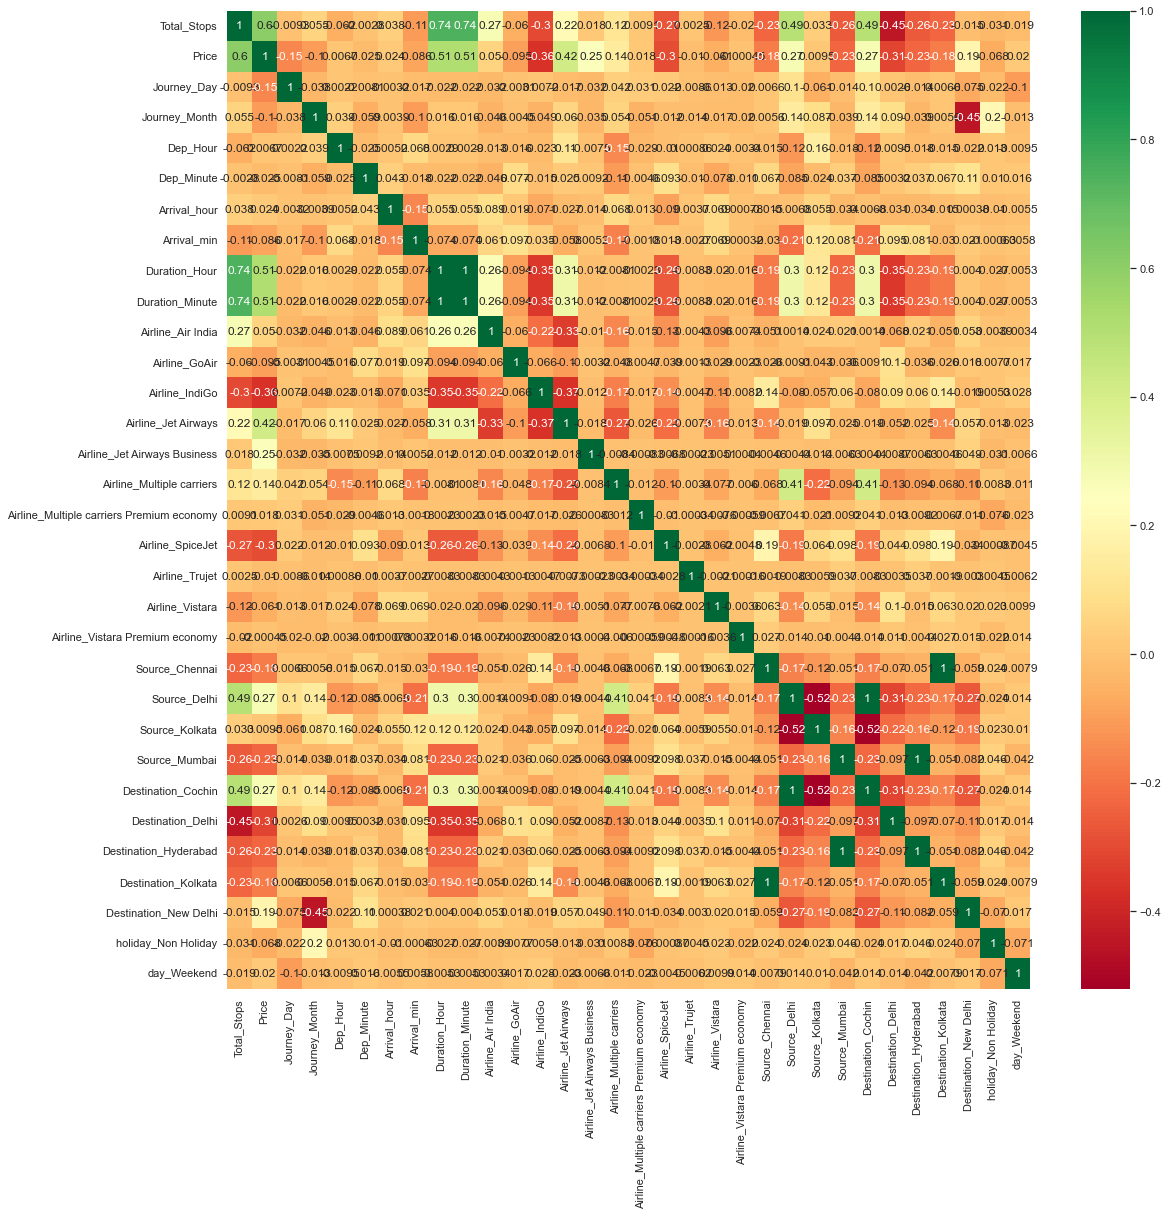

In [90]:
# Finds correlation between Independent and dependent attributes

plt.figure(figsize = (18,18))
sns.heatmap(df.corr(), annot = True, cmap = "RdYlGn")

plt.show()

In [91]:
# Important feature using ExtraTreesRegressor(XG Boost)

from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

In [92]:
# decision tree concept having selection purpose.
print(selection.feature_importances_)

[0.17594509 0.09511004 0.06418972 0.03160226 0.02923322 0.03669801
 0.0250676  0.10785547 0.1051229  0.01902588 0.003351   0.02506157
 0.13100821 0.01619137 0.0056705  0.00490094 0.0010548  0.01284431
 0.013996   0.00649939 0.01519232 0.01270337 0.00397919 0.00104803
 0.04765515 0.00899366]


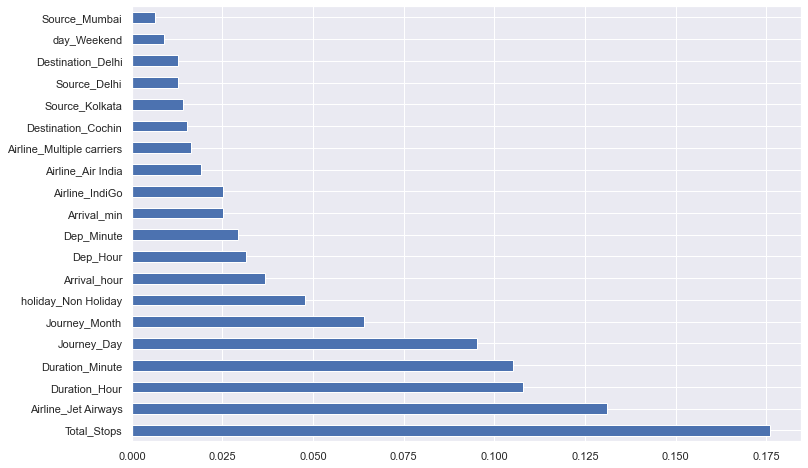

In [93]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [94]:
#  Fitting model using Random Forest

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [95]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor()

In [96]:
y_pred = reg_rf.predict(X_test)

In [97]:
reg_rf.score(X_train, y_train)

0.9501783168358157

In [98]:
reg_rf.score(X_test, y_test)

0.7936821794040294

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


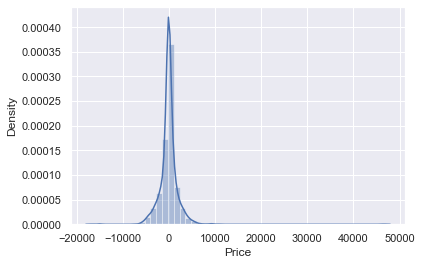

In [99]:
sns.distplot(y_test-y_pred)
plt.show()

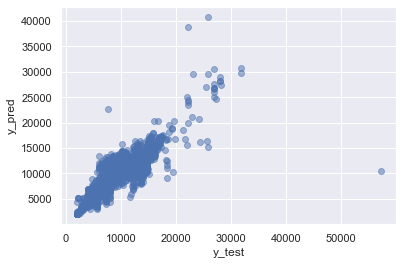

In [100]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [101]:
from sklearn import metrics

In [102]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1140.1689149467882
MSE: 4355732.516483804
RMSE: 2087.0391746404293


In [103]:
metrics.r2_score(y_test, y_pred)

0.7936821794040294

In [104]:
#Hyperparameter Tuning
#Choose following method for hyperparameter tuning
#RandomizedSearchCV --> Fast
#GridSearchCV


from sklearn.model_selection import RandomizedSearchCV

In [105]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [106]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [107]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [108]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   9.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   8.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   8.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   8.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   7.9s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=  11.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=  12.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [109]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [110]:
prediction = rf_random.predict(X_test)

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


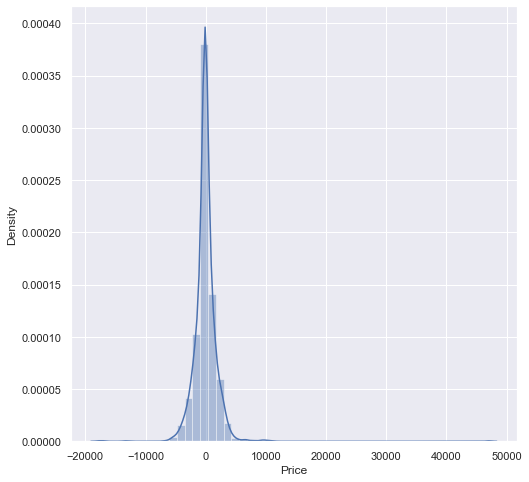

In [111]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

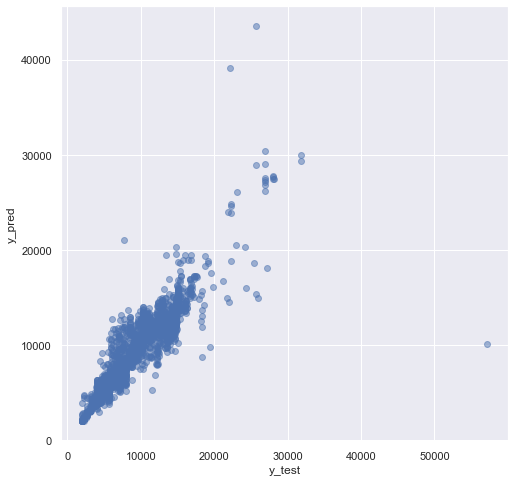

In [112]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [113]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 1121.2318651272942
MSE: 4034522.369005813
RMSE: 2008.6120503984368


In [114]:
#### Extra step-2
metrics.r2_score(y_test, prediction)

0.8088969285490176

In [115]:
#Pikel File for our model
pickle.dump(reg_rf, open("model.pkl", "wb"))